In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [113]:
suptitles = {a+topo : a+", "+{'_2pi':r"$\pi\pi$", '_pi_p':r"$\pi p$"}[topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p'.split()}

In [2]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [3]:
import time
import numpy as np
import pandas as pd
#import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
#from root_pandas import read_root
from matplotlib import rc
from numpy import inf


import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

#import root_pandas
%matplotlib inline

import uproot

rc('text', usetex=True)

import matplotlib as mpl
#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

In [4]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [5]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [6]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(tensorflow.keras.__version__)  # 2.2.4

2.3.1
2.4.0


## Obtain datasets and simulations

In [7]:
import root_pandas
dfs_all = {a : root_pandas.read_root("/home/seba/CreatePairTuples/Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}
#now load MC
dfs_all.update({'MC_'+a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a) for a in "Pb D C Fe".split()})
dfs_all['D'] = pd.concat([dfs_all['D_'+a] for a in 'C Fe Pb'.split()])

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [8]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 and Q2<4.0')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions (trigger)')
    dataframe = applyCut(dataframe, 'nu>2.2 and nu<4.2', 'Nu>2.2 and Nu<4.2')
    dataframe = applyCut(dataframe, 'h1_z <1.0', 'h1_z <1.0')
   
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False,dipion=False,pi_p=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('pair_pt = sqrt((h1_p*sin(h1_th)*cos(h1_ph)+h2_p*sin(h2_th)*cos(h2_ph))**2+(h1_p*sin(h1_th)*sin(h1_ph)+h2_p*sin(h2_th)*sin(h2_ph))**2)',inplace=True)
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0 and Q2<4.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p<2.5', 'h1_p<2.5 GeV ')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p<2.5 GeV')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    if dipion:
        dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'secondary hadrons are pions') 
    if pi_p:
        dataframe = applyCut(dataframe, 'h2_pid==2212', 'secondary hadrons are protons') 
    dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
    dataframe = applyCut(dataframe, 'h1_p>0.2', 'h1_p>0.2')
    dataframe = applyCut(dataframe, 'h2_z<1.0', 'h1_z<1.0')
    
    #convert stuff to radians
    if(max(dataframe[:1000].h2_th)>np.pi):
        for f in 'h2_th h1_th h1_ph h2_ph'.split():
            dataframe[f]*=np.pi/180
    ## Theta cuts are not applied in the GiBUU case
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120*3.14159/180 and h2_th>10*3.14159/180', '10<h2_th<120')
        dataframe = applyCut(dataframe, '(h2_pid==2212) | (h2_pid==211) | (h2_pid==-211 & h2_th>25*3.14159/180 & h2_th<90*3.14159/180) | (h2_pid==-211 & h2_th<40*3.14159/180 & h2_th>25*3.14159/180 & h2_p>0.5)','Theta/P fiducial region selected')
        dataframe = applyCut(dataframe, 'h1_th<120*3.14159/180 and h1_th>10*3.14159/180', '10< h1_th<120')
        dataframe = applyCut(dataframe, '(h1_pid==211) | (h1_pid==-211 & h1_th>25*3.14159/180 & h1_th<90*3.14159/180) | (h1_pid==-211 & h1_th<40*3.14159/180 & h1_th>25*3.14159/180 & h1_p>0.5)','Theta/P fiducial region selected for trigger')
        
    return dataframe



for key in list(dfs_all.keys()):
    if '_2pi' in key or '_pi_p' in key:
        continue
    df = dfs_all[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.rename(columns={'drap':'diff_rap_cm'},inplace=True)
    print(df.columns)
    dfs_all[key+"_2pi"] = applyCuts(applyCutsPair(df,dipion=True))
    dfs_all[key+"_pi_p"] = applyCuts(applyCutsPair(df,pi_p=True))
# for key in list(dfs_mixed.keys()): 
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     print('key is ',key)
#     dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
#     dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
# for key in list(dfs_trigger.keys()):
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     dfs_trigger[key] = applyCuts(dfs_trigger[key])

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x', 'u',
       'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p'],
      dtype='object')
Starting election on dipion variables
This is Data
Q2>1.0 : 932821  (100.00  %)
h1_z>0.5 : 530131  (56.83  %)
h1_p<2.5 GeV  454397  (85.71  %)
h2_p<

Nu>2.2 and Nu<4.2 38334  (98.81  %)
h1_z <1.0 38334  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 1865381  (100.00  %)
h1_z>0.5 : 734962  (39.40  %)
h1_p<2.5 GeV  656707  (89.35  %)
h2_p<2.5 GeV 656429  (99.96  %)
secondary hadrons are protons 270936  (41.27  %)
h2_p>0.2 270936  (100.00  %)
h1_p>0.2 270936  (100.00  %)
h1_z<1.0 270917  (99.99  %)
10<h2_th<120 270917  (100.00  %)
Theta/P fiducial region selected 270917  (100.00  %)
10< h1_th<120 270917  (100.00  %)
Theta/P fiducial region selected for trigger 53099  (19.60  %)
Entries before cut  53099
Q2>1.0 and Q2<4.0 53099  (100.00  %)
h1_p<2.5  53099  (100.00  %)
inelasticity < 0.85 53099  (100.00  %)
h1_pid = pions (trigger) 53099  (100.00  %)
Nu>2.2 and Nu<4.2 52521  (98.91  %)
h1_z <1.0 52521  (100.00  %)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th',

Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are pions 840592  (81.54  %)
h2_p>0.2 840592  (100.00  %)
h1_p>0.2 840592  (100.00  %)
h1_z<1.0 840592  (100.00  %)
10<h2_th<120 840592  (100.00  %)
Theta/P fiducial region selected 840592  (100.00  %)
10< h1_th<120 840592  (100.00  %)
Theta/P fiducial region selected for trigger 150658  (17.92  %)
Entries before cut  150658
Q2>1.0 and Q2<4.0 150658  (100.00  %)
h1_p<2.5  150658  (100.00  %)
inelasticity < 0.85 150658  (100.00  %)
h1_pid = pions (trigger) 150658  (100.00  %)
Nu>2.2 and Nu<4.2 148213  (98.38  %)
h1_z <1.0 148213  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 2196429  (100.00  %)
h1_z>0.5 : 1350443  (61.48  %)
h1_p<2.5 GeV  1033362  (76.52  %)
h2_p<2.5 GeV 1030935  (99.77  %)
secondary hadrons are protons 190343  (18.46  %)
h2_p>0.2 190343  (100.00  %)
h1_p>0.2 190343  (100.00  %)
h1_z<1.0 190341  (100

Nu>2.2 and Nu<4.2 180707  (99.21  %)
h1_z <1.0 180707  (100.00  %)


In [9]:
for df in dfs_all.values(): 
    df['pass_reco'] = np.where(df['h2_cm_pt']>0, 1, 0)
    if 'h2_truth_cm_pt' in df.columns:
        df['pass_truth'] = np.where(df['h2_truth_cm_pt']*df['Q2']>0, 1, 0)
    else:
        df['pass_truth'] = np.where(df['Q2']>0, 1, 0)


#mc_hadron['pass_reco'] = np.where(mc_hadron['h_cm_pt']>0, 1, 0)
#mc_hadron['pass_truth'] = np.where(mc_hadron['h_truth_cm_pt']*mc_hadron['Q2']>0, 1, 0)
#data_hadron['pass_reco'] = np.where(data_hadron['h_cm_pt']>0, 1, 0)

In [10]:
#patch the things that are zero
for df in dfs_all.values():
    for column in df.columns:
        if "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_truth+(1-df.pass_truth)*-9999
        if not "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_reco+(1-df.pass_reco)*-9999



In [11]:
dfs_data = {a+topo : dfs_all[a+topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p'.split()}
dfs_mc = {a+topo : dfs_all['MC_' + a+topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p'.split()}

## You want reasonable sample of MC,
## Try at minimum e.g x 3 the data size

In [12]:

for key in dfs_data.keys():
    print(key, len(dfs_data[key]), len(dfs_mc[key]), len(dfs_mc[key])*1./len(dfs_data[key]))
    trimlength = int(len(dfs_mc[key])/3)
    dfs_data[key] = dfs_data[key][:trimlength]
#print(len(data))
#print(len(mc.query('pass_reco==1'))) ##only what is really reconstructed counts
#print(len(mc)) ##only what is really reconstructed counts

D_2pi 221189 148213 0.6700740091053352
D_pi_p 180707 184059 1.01854936444078
C_2pi 37019 147317 3.9794970150463276
C_pi_p 41374 181808 4.394257263015421
Fe_2pi 38334 136376 3.5575729117754475
Fe_pi_p 52521 168807 3.214085794253727
Pb_2pi 12836 143937 11.213540043627297
Pb_pi_p 18791 177509 9.44649034112075


## Unfold Data

In [13]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim=None,weights_MC_data=None,verbose=1):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(theta0_S))
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    history = {}
    history['step1'] = []
    history['step2'] = []
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=10000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        
        hist_s1 =  model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step1'].append(hist_s1)
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        hist_s2 = model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step2'].append(hist_s2)

        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model, history

 

In [14]:
help(multifold)

Help on function multifold in module __main__:

multifold(num_observables, iterations, theta0_G, theta0_S, theta_unknown_S, weights_MC_sim=None, weights_MC_data=None, verbose=1)



In [15]:
def run_omnifold(df_data,df_mc, observable_names_reco, observable_names_truth, iterations=4):
    K.clear_session()
    
    num_observables = len(observable_names_reco)
    theta0_G=np.c_[tuple((np.array(df_mc[obs]) for obs in observable_names_truth))]
    theta0_S=np.c_[tuple((np.array(df_mc[obs]) for obs in observable_names_reco))]
    theta_unknown_S=np.c_[tuple((np.array(df_data[obs]) for obs in observable_names_reco))]

    print(len(df_mc))
    print(theta0_S)
    print(len(theta0_G[0]))
    print(len(df_mc))
    pass_reco = np.array(df_mc['pass_reco'])
    pass_truth = np.array(df_mc['pass_truth'])
    theta0_S[:,0][pass_reco==0] = -10
    theta0_G[:,0][pass_truth==0] = -10


    import time,os
    start = time.perf_counter()
    #try:
    weights, model, history = multifold(num_observables=num_observables,
                           iterations=iterations,
                           theta0_G=theta0_G,
                           theta0_S=theta0_S,
                           theta_unknown_S= theta_unknown_S)

    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
    os.system('say "your program has finished"')
    
    return weights, model, history
#finally : 
#    duration = time.perf_counter()-start
#    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
#    os.system('say "your program has crashed"')

In [116]:

dfs_data = dict(dfs_data)
dfs_mc = dict(dfs_mc)

weights = {}
models = {}
histories = {}

variables = 'diff_rap_cm diff_phi_cm h1_z h2_z x Q2 h1_cm_pt h2_cm_pt'.split()

for a in 'D C Fe Pb'.split():
    for topo in '_2pi _pi_p'.split():
        name = a+topo
        if not name in ('C_2pi', 'C_pi_p'):#for now, only do this for the carbon MCs
            continue
        weights[name], models[name], histories[name] = run_omnifold(dfs_data[name],dfs_mc[name], variables, variables, iterations=4)
            
        

147317
[[ 1.77104454 -0.27453456  0.5905394  ...  2.00657082  0.07969573
   0.22318425]
 [ 1.16651597 -1.42686599  0.53903883 ...  1.38640463  0.6616396
   0.54999937]
 [ 2.36004828 -1.17535039  0.63728587 ...  1.30249298  0.22627613
   0.23046345]
 ...
 [ 0.75568621 -2.86820436  0.57037245 ...  1.41359448  0.67461042
   0.70881602]
 [ 2.56519957 -0.52089411  0.77799115 ...  1.97895992  0.20521686
   0.19150491]
 [ 0.54271517 -2.21596186  0.53950243 ...  1.581218    0.77927571
   0.18371841]]
8
147317

ITERATION: 1

STEP 1

Epoch 1/200
14/14 [==============================] - 1s 59ms/step - loss: 0.5199 - accuracy: 0.3999 - val_loss: 0.5136 - val_accuracy: 0.3987
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.3999 - val_loss: 0.5000 - val_accuracy: 0.3987
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4932 - accuracy: 0.3999 - val_loss: 0.4917 - val_accuracy: 0.3987
Epoch 4/200
14/14 [===========================

14/14 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.4003 - val_loss: 0.4626 - val_accuracy: 0.3989
Epoch 56/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.4002 - val_loss: 0.4622 - val_accuracy: 0.3993
Epoch 57/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4616 - accuracy: 0.4003 - val_loss: 0.4630 - val_accuracy: 0.3989
Epoch 58/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4615 - accuracy: 0.4004 - val_loss: 0.4623 - val_accuracy: 0.3989
Epoch 59/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.4002 - val_loss: 0.4621 - val_accuracy: 0.3994
Epoch 60/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4614 - accuracy: 0.4002 - val_loss: 0.4619 - val_accuracy: 0.3994
Epoch 61/200
14/14 [==============================] - 0s 3ms/step - loss: 0.4613 - accuracy: 0.4004 - val_loss: 0.4618 - val_accuracy: 0.3994
Epoch 62/200
14/14 

14/14 [==============================] - 0s 2ms/step - loss: 0.2808 - accuracy: 0.3541 - val_loss: 0.2785 - val_accuracy: 0.3587
Epoch 12/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.3494 - val_loss: 0.2785 - val_accuracy: 0.3353
Epoch 13/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2807 - accuracy: 0.3549 - val_loss: 0.2784 - val_accuracy: 0.3488
Epoch 14/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2807 - accuracy: 0.3492 - val_loss: 0.2785 - val_accuracy: 0.3341
Epoch 15/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2806 - accuracy: 0.3534 - val_loss: 0.2784 - val_accuracy: 0.3620
Epoch 16/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2806 - accuracy: 0.3542 - val_loss: 0.2785 - val_accuracy: 0.3258
Epoch 17/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.3572 - val_loss: 0.2784 - val_accuracy: 0.3542
Epoch 18/200
14/14 

23/23 [==============================] - 0s 2ms/step - loss: 0.2866 - accuracy: 0.2500 - val_loss: 0.2862 - val_accuracy: 0.2505
Epoch 22/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.2500 - val_loss: 0.2861 - val_accuracy: 0.2506
Epoch 23/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2867 - accuracy: 0.2500 - val_loss: 0.2861 - val_accuracy: 0.2505
Epoch 24/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.2500 - val_loss: 0.2860 - val_accuracy: 0.2505
Epoch 25/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.2500 - val_loss: 0.2861 - val_accuracy: 0.2505
Epoch 26/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2866 - accuracy: 0.2501 - val_loss: 0.2861 - val_accuracy: 0.2505
Epoch 27/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.2500 - val_loss: 0.2861 - val_accuracy: 0.2507
Epoch 28/200
23/23 

14/14 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.3172 - val_loss: 0.2760 - val_accuracy: 0.3305
Epoch 44/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2746 - accuracy: 0.3229 - val_loss: 0.2760 - val_accuracy: 0.3305
Epoch 45/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2746 - accuracy: 0.3114 - val_loss: 0.2760 - val_accuracy: 0.3313
Epoch 46/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2746 - accuracy: 0.3170 - val_loss: 0.2760 - val_accuracy: 0.3228
Epoch 47/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.3275 - val_loss: 0.2760 - val_accuracy: 0.3117
Epoch 48/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.3173 - val_loss: 0.2760 - val_accuracy: 0.3051
Epoch 49/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2746 - accuracy: 0.3293 - val_loss: 0.2760 - val_accuracy: 0.3108
Epoch 50/200
14/14 

Epoch 101/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.3243 - val_loss: 0.2757 - val_accuracy: 0.3330
Epoch 102/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2739 - accuracy: 0.3167 - val_loss: 0.2757 - val_accuracy: 0.3261
Epoch 103/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.3214 - val_loss: 0.2757 - val_accuracy: 0.3416
Epoch 104/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2740 - accuracy: 0.3207 - val_loss: 0.2757 - val_accuracy: 0.3327
Epoch 105/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.3176 - val_loss: 0.2757 - val_accuracy: 0.2835
Epoch 106/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2739 - accuracy: 0.3136 - val_loss: 0.2757 - val_accuracy: 0.2946
Epoch 107/200
14/14 [==============================] - 0s 3ms/step - loss: 0.2739 - accuracy: 0.3194 - val_loss: 0.2756 - val_accuracy: 0.2930

23/23 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.2508 - val_loss: 0.2872 - val_accuracy: 0.2498
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2865 - accuracy: 0.2507 - val_loss: 0.2870 - val_accuracy: 0.2502
Epoch 8/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2864 - accuracy: 0.2507 - val_loss: 0.2870 - val_accuracy: 0.2502
Epoch 9/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.2507 - val_loss: 0.2869 - val_accuracy: 0.2500
Epoch 10/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.2508 - val_loss: 0.2870 - val_accuracy: 0.2502
Epoch 11/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2862 - accuracy: 0.2507 - val_loss: 0.2870 - val_accuracy: 0.2500
Epoch 12/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.2506 - val_loss: 0.2869 - val_accuracy: 0.2502
Epoch 13/200
23/23 [==

23/23 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.2497 - val_loss: 0.2843 - val_accuracy: 0.2520
Epoch 10/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.2497 - val_loss: 0.2844 - val_accuracy: 0.2519
Epoch 11/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2842 - accuracy: 0.2496 - val_loss: 0.2845 - val_accuracy: 0.2520
Epoch 12/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.2496 - val_loss: 0.2843 - val_accuracy: 0.2519
Epoch 13/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.2496 - val_loss: 0.2842 - val_accuracy: 0.2520
Epoch 14/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.2496 - val_loss: 0.2843 - val_accuracy: 0.2519
Epoch 15/200
23/23 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.2496 - val_loss: 0.2842 - val_accuracy: 0.2521
Epoch 16/200
23/23 

17/17 [==============================] - 0s 2ms/step - loss: 0.3804 - accuracy: 0.4620 - val_loss: 0.3873 - val_accuracy: 0.4567
Epoch 36/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3790 - accuracy: 0.4618 - val_loss: 0.3861 - val_accuracy: 0.4601
Epoch 37/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.4629 - val_loss: 0.3849 - val_accuracy: 0.4608
Epoch 38/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3772 - accuracy: 0.4633 - val_loss: 0.3835 - val_accuracy: 0.4621
Epoch 39/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3763 - accuracy: 0.4643 - val_loss: 0.3829 - val_accuracy: 0.4600
Epoch 40/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3760 - accuracy: 0.4637 - val_loss: 0.3840 - val_accuracy: 0.4697
Epoch 41/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3768 - accuracy: 0.4642 - val_loss: 0.3819 - val_accuracy: 0.4595
Epoch 42/200
17/17 

Epoch 93/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3623 - accuracy: 0.4691 - val_loss: 0.3701 - val_accuracy: 0.4631
Epoch 94/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.4693 - val_loss: 0.3690 - val_accuracy: 0.4722
Epoch 95/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3613 - accuracy: 0.4704 - val_loss: 0.3679 - val_accuracy: 0.4668
Epoch 96/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.4701 - val_loss: 0.3681 - val_accuracy: 0.4681
Epoch 97/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3609 - accuracy: 0.4695 - val_loss: 0.3684 - val_accuracy: 0.4686
Epoch 98/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.4700 - val_loss: 0.3683 - val_accuracy: 0.4680
Epoch 99/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3606 - accuracy: 0.4703 - val_loss: 0.3681 - val_accuracy: 0.4641
Epoch 

17/17 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.4708 - val_loss: 0.3616 - val_accuracy: 0.4676
Epoch 151/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.4708 - val_loss: 0.3627 - val_accuracy: 0.4655
Epoch 152/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3549 - accuracy: 0.4706 - val_loss: 0.3624 - val_accuracy: 0.4667
Epoch 153/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.4710 - val_loss: 0.3614 - val_accuracy: 0.4683
Epoch 154/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.4708 - val_loss: 0.3623 - val_accuracy: 0.4667
Epoch 155/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3548 - accuracy: 0.4705 - val_loss: 0.3621 - val_accuracy: 0.4733
Epoch 156/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3549 - accuracy: 0.4708 - val_loss: 0.3619 - val_accuracy: 0.4667
Epoch 157/200

Epoch 25/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3575 - accuracy: 0.3014 - val_loss: 0.3506 - val_accuracy: 0.2605
Epoch 26/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3550 - accuracy: 0.2763 - val_loss: 0.3500 - val_accuracy: 0.3048
Epoch 27/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3527 - accuracy: 0.2941 - val_loss: 0.3491 - val_accuracy: 0.2918
Epoch 28/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3510 - accuracy: 0.2877 - val_loss: 0.3471 - val_accuracy: 0.2879
Epoch 29/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3499 - accuracy: 0.2720 - val_loss: 0.3467 - val_accuracy: 0.2974
Epoch 30/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.2867 - val_loss: 0.3442 - val_accuracy: 0.2571
Epoch 31/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.2799 - val_loss: 0.3445 - val_accuracy: 0.2950
Epoch 

Epoch 83/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3033 - accuracy: 0.2484 - val_loss: 0.3075 - val_accuracy: 0.2720
Epoch 84/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.2583 - val_loss: 0.3101 - val_accuracy: 0.2046
Epoch 85/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3029 - accuracy: 0.2482 - val_loss: 0.3085 - val_accuracy: 0.2233
Epoch 86/200
17/17 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.2750 - val_loss: 0.3066 - val_accuracy: 0.2151
Epoch 87/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3008 - accuracy: 0.2629 - val_loss: 0.3076 - val_accuracy: 0.2264
Epoch 88/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3004 - accuracy: 0.2598 - val_loss: 0.3070 - val_accuracy: 0.2186
Epoch 89/200
17/17 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.2478 - val_loss: 0.3074 - val_accuracy: 0.2787
Epoch 

17/17 [==============================] - 0s 2ms/step - loss: 0.2923 - accuracy: 0.2900 - val_loss: 0.3001 - val_accuracy: 0.2193
Epoch 141/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2913 - accuracy: 0.2710 - val_loss: 0.3056 - val_accuracy: 0.3029
Epoch 142/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2941 - accuracy: 0.2739 - val_loss: 0.3066 - val_accuracy: 0.3929
Epoch 143/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.2903 - val_loss: 0.3005 - val_accuracy: 0.3178
Epoch 144/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2911 - accuracy: 0.3153 - val_loss: 0.2999 - val_accuracy: 0.3070
Epoch 145/200
17/17 [==============================] - 0s 3ms/step - loss: 0.2903 - accuracy: 0.2806 - val_loss: 0.3047 - val_accuracy: 0.2731
Epoch 146/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2914 - accuracy: 0.2929 - val_loss: 0.3008 - val_accuracy: 0.1880
Epoch 147/200

28/28 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.2536 - val_loss: 0.2144 - val_accuracy: 0.2555
Epoch 34/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2138 - accuracy: 0.2536 - val_loss: 0.2153 - val_accuracy: 0.2531
Epoch 35/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.2536 - val_loss: 0.2140 - val_accuracy: 0.2543
Epoch 36/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2135 - accuracy: 0.2535 - val_loss: 0.2142 - val_accuracy: 0.2557
Epoch 37/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.2536 - val_loss: 0.2139 - val_accuracy: 0.2545
Epoch 38/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.2536 - val_loss: 0.2140 - val_accuracy: 0.2539
Epoch 39/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.2536 - val_loss: 0.2141 - val_accuracy: 0.2535
Epoch 40/200
28/28 

17/17 [==============================] - 0s 2ms/step - loss: 0.2423 - accuracy: 0.2742 - val_loss: 0.2464 - val_accuracy: 0.3659
Epoch 16/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.3015 - val_loss: 0.2461 - val_accuracy: 0.2216
Epoch 17/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.2886 - val_loss: 0.2453 - val_accuracy: 0.2965
Epoch 18/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.2856 - val_loss: 0.2464 - val_accuracy: 0.2834
Epoch 19/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.2884 - val_loss: 0.2452 - val_accuracy: 0.2416
Epoch 20/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.2756 - val_loss: 0.2451 - val_accuracy: 0.2793
Epoch 21/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.2783 - val_loss: 0.2451 - val_accuracy: 0.2631
Epoch 22/200
17/17 

28/28 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.2551 - val_loss: 0.2329 - val_accuracy: 0.2551
Epoch 36/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.2551 - val_loss: 0.2333 - val_accuracy: 0.2553
Epoch 37/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.2553 - val_loss: 0.2333 - val_accuracy: 0.2548
Epoch 38/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.2552 - val_loss: 0.2329 - val_accuracy: 0.2542
Epoch 39/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.2551 - val_loss: 0.2327 - val_accuracy: 0.2541
Epoch 40/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2320 - accuracy: 0.2551 - val_loss: 0.2343 - val_accuracy: 0.2571
Epoch 41/200
28/28 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.2551 - val_loss: 0.2328 - val_accuracy: 0.2547
Epoch 42/200
28/28 

17/17 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.3749 - val_loss: 0.2511 - val_accuracy: 0.3208
Epoch 43/200
17/17 [==============================] - 0s 3ms/step - loss: 0.2515 - accuracy: 0.3699 - val_loss: 0.2508 - val_accuracy: 0.3382
Epoch 44/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.3609 - val_loss: 0.2510 - val_accuracy: 0.3468
Epoch 45/200
17/17 [==============================] - 0s 3ms/step - loss: 0.2513 - accuracy: 0.3680 - val_loss: 0.2517 - val_accuracy: 0.3552
Epoch 46/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.3548 - val_loss: 0.2511 - val_accuracy: 0.3880
Epoch 47/200
17/17 [==============================] - 0s 3ms/step - loss: 0.2516 - accuracy: 0.3684 - val_loss: 0.2506 - val_accuracy: 0.3512
Epoch 48/200
17/17 [==============================] - 0s 2ms/step - loss: 0.2515 - accuracy: 0.3576 - val_loss: 0.2509 - val_accuracy: 0.3325
Epoch 49/200
17/17 

In [117]:
print(dfs_mc['C_2pi'].columns)
    

Index(['dphi', 'dphi_lab', 'diff_rap_cm', 'h1_z', 'h2_z', 'h1_cm_pt',
       'h2_cm_pt', 'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid',
       'h2_pid', 'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass',
       'pair_pt', 'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x',
       'u', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', '__index__', 'inelasticity',
       'diff_phi_cm', 'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p', 'z_tot',
       'pair_pt2', 'pass_reco', 'pass_truth', 'diff_phi_lab', 'weight_reco',
       'weight_truth'],
      dtype='object')


In [127]:
#list all data in history
# summarize history for accuracy

def make_history_plots(key):
    history = histories[key]
    for i in range(4):
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('Step 1: \nreweight sim. from data')
        ax[0].set_xlabel('epoch number')
        ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train loss')
        ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test loss')
        ax[0].legend()

        #ax[1].set_title('model accuracy')
        #ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
        #ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
        #ax[1].legend()
        #ax[1].set_xlabel('epoch number')

        ax[1].set_title('Step 2: \nreweight gen. from sim.')
        ax[1].set_xlabel('epoch number')
        ax[1].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train loss')
        ax[1].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test loss')
        ax[1].legend()

        #ax[3].set_title('model accuracy')
        #ax[3].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
        #ax[3].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
        #ax[3].legend()
        #ax[3].set_xlabel('epoch number')

        #for a in ax:
        #    a.set_ylim(0)
        plt.savefig(f"../images/reweight_history_iter_{i}_{key}.png")

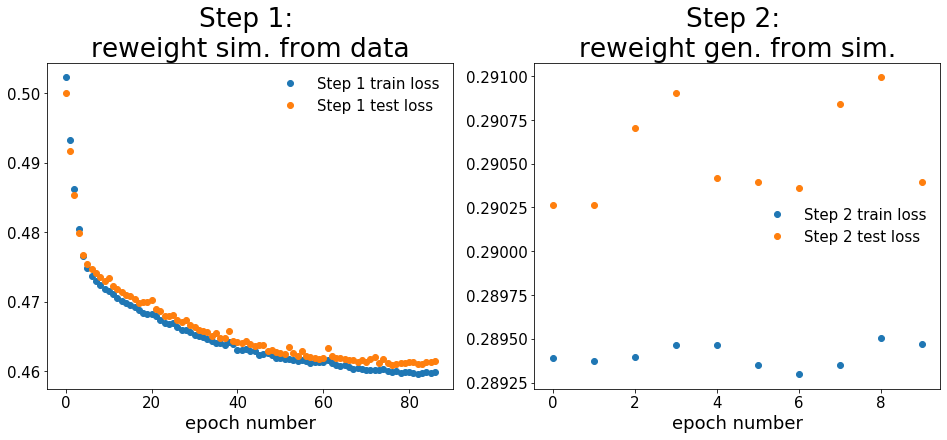

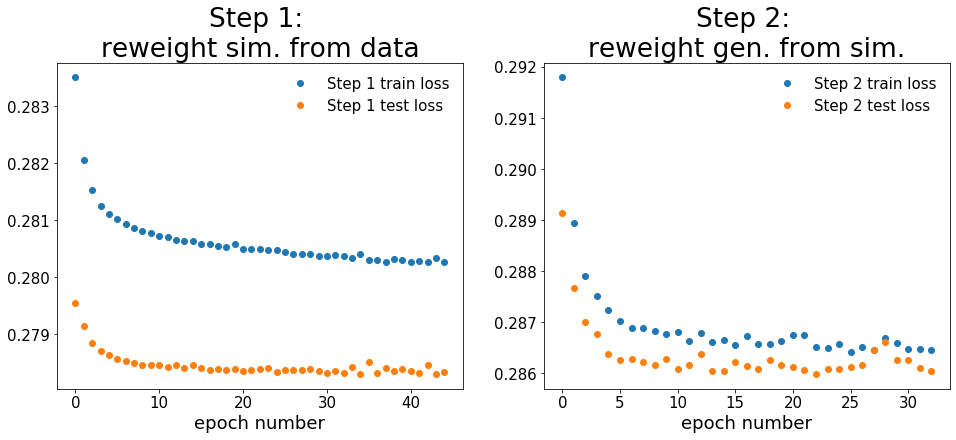

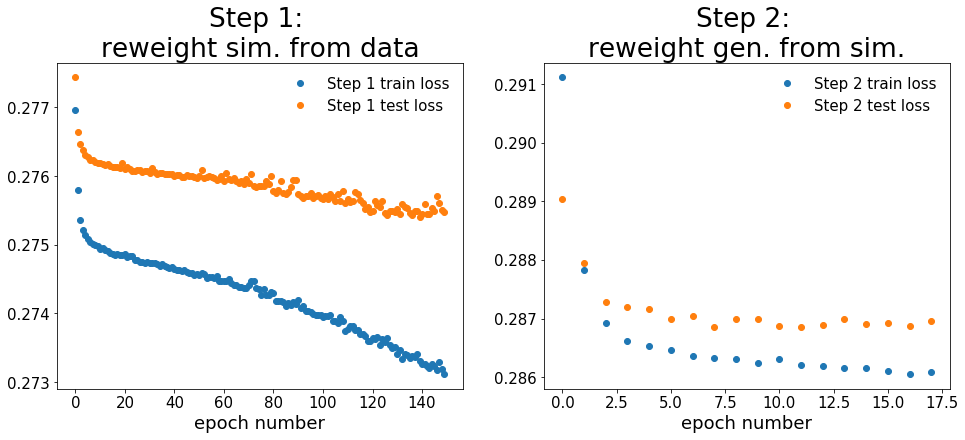

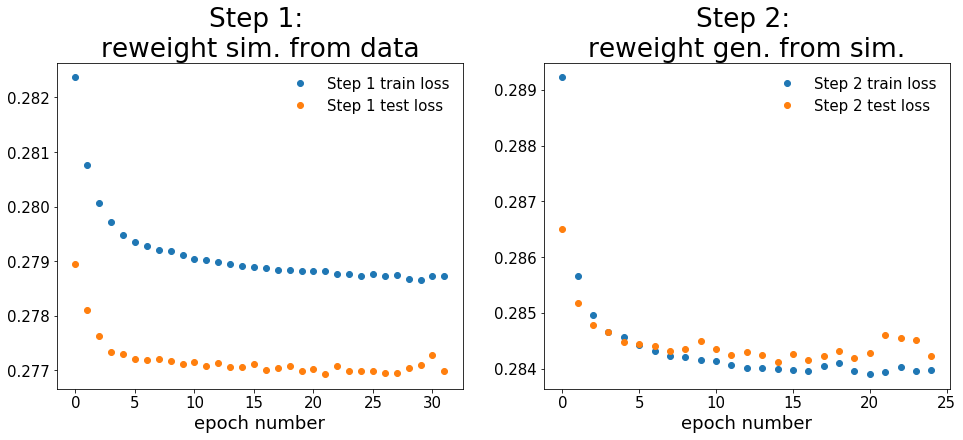

In [128]:
make_history_plots('C_2pi')

## Plot data and MC reweighted

In [129]:
## This is what in Ben's notebook. 
## The _S is RECO level. 
## You require that the RECO dataframe has a valid pass reco.
## The G is the truth level
## You required that the truth level has pass_truth valid.

In [130]:
#


def reweight_summary_plots(setname):
    df_data = dfs_data[setname]
    df_mc = dfs_mc[setname]
    for i in range(len(weights[setname])):
        pass_reco = df_mc.pass_reco != 0
        print(len(pass_reco))
        print("ITERATION: {}".format(i + 1))
        for df in df_data, df_mc:
            if not 'diff_phi_lab' in df.columns:
                df.eval('diff_phi_lab = (h1_ph-h2_ph)',inplace=True)
                df['diff_phi_lab'] = df.diff_phi_lab+(df.diff_phi_lab>np.pi)*-np.pi*2+(df.diff_phi_lab<-np.pi)*np.pi*2
        fig, ax = plt.subplots(3,
                               3,
                               figsize=(16, 16),
                               constrained_layout=True)
        fig.suptitle(suptitles[setname] + f", iter. {i}")

        bins = [[np.linspace(0.0, 4.2, 40), np.linspace(2.0, 5, 20), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(-.5, 3, 50)]]
        xlabels = [[r'$Q^{2}$', r'$\nu$', r'$\Delta\phi_{\mathrm{lab}}$'],
                  [r'$z_1$', r'$p^1_T$', r'$\Delta\phi_{\mathrm{cm}}$'],
                  [r'$z_2$', r'$p^2_T$', r'$\Delta y_{\mathrm{cm}}$']]
        xvars = [['Q2', 'nu', 'diff_phi_lab'],
                ['h1_z', 'h1_cm_pt','diff_phi_cm'],
                ['h2_z', 'h2_cm_pt','diff_rap_cm']]

        for row in range(3):
            for col in range(3):

                ax[row,col].set_xlabel(xlabels[row][col])
                ax[row,col].set_ylabel('Events per bin (Normalized)')
                ax[row,col].hist(df_mc[xvars[row][col]][pass_reco], bins=bins[row][col], label=r'MC .', **plot_style_2)
                #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

                ax[row,col].hist(df_mc[xvars[row][col]][pass_reco],
                           bins=bins[row][col],
                           weights=weights[setname][i, 0, :][pass_reco],
                           label=r'MC . DCTR wgt.',
                           **plot_style_1)

                ax[row,col].hist(df_data[xvars[row][col]],
                           bins=bins[row][col],
                           label=r'Data (reco)',
                           **plot_style_2)
                if row == 0 and col == 0:
                    ax[row,col].legend(frameon=False,loc='best')


        fig.savefig(f"../images/reweight_summary_{setname}_iter{i}.png")

147317
ITERATION: 1
147317
ITERATION: 2
147317
ITERATION: 3
147317
ITERATION: 4
181808
ITERATION: 1
181808
ITERATION: 2
181808
ITERATION: 3
181808
ITERATION: 4


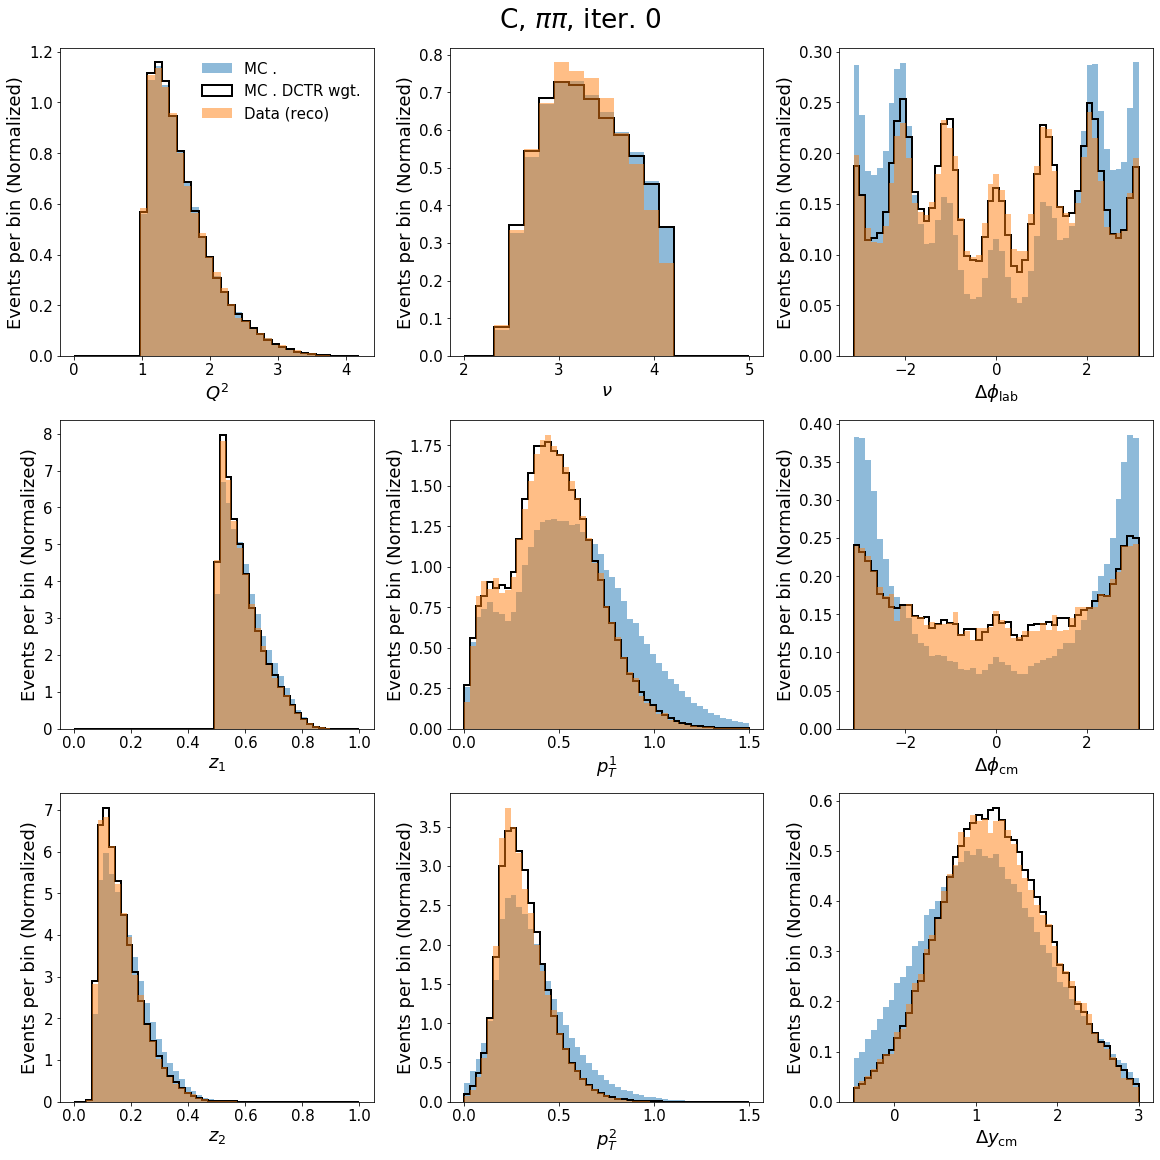

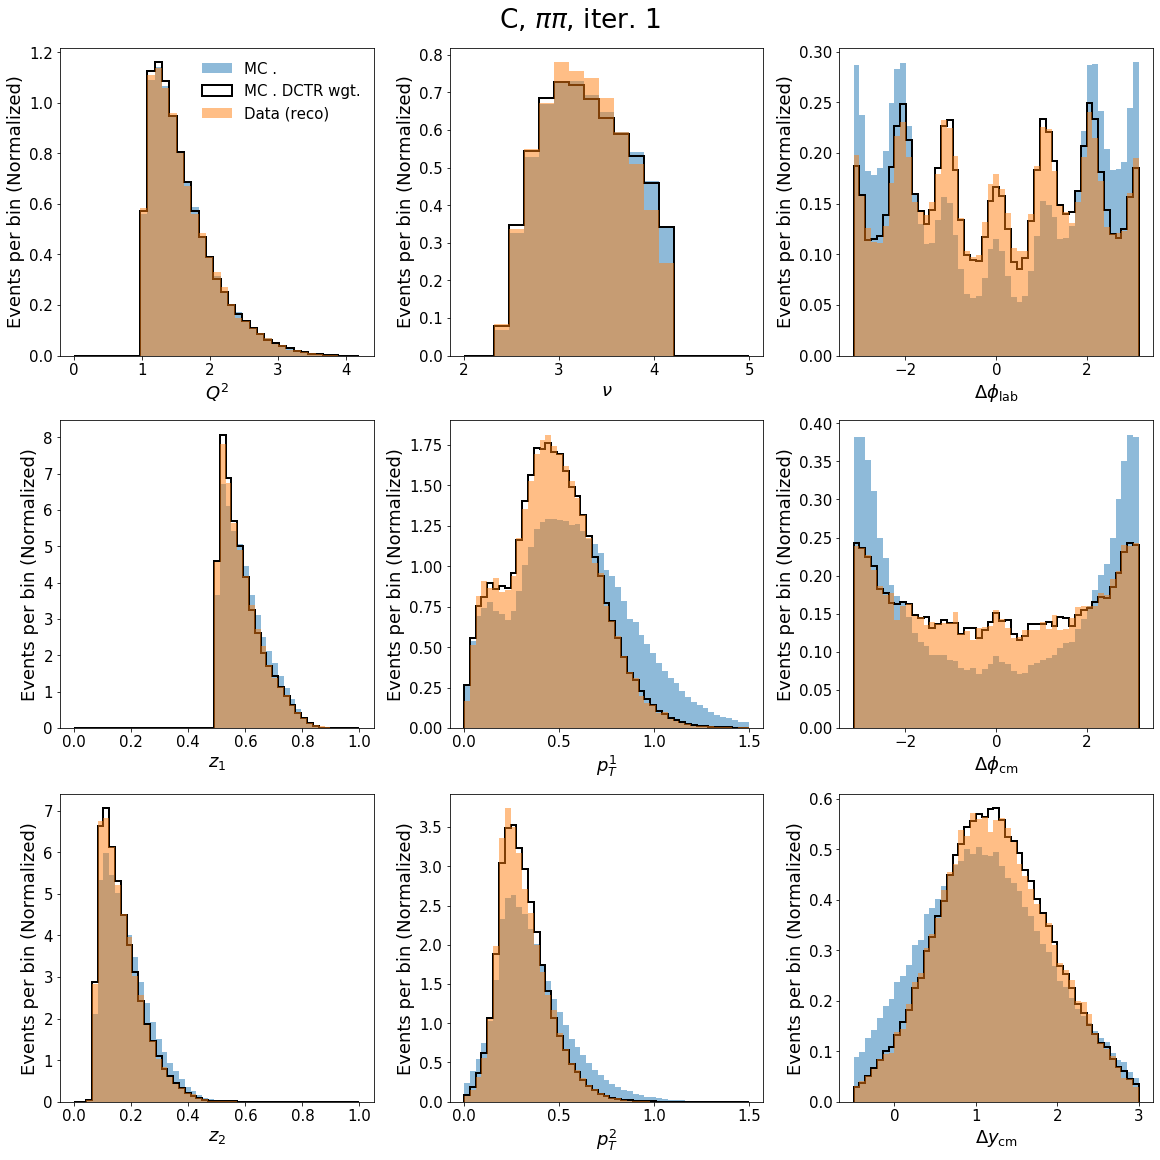

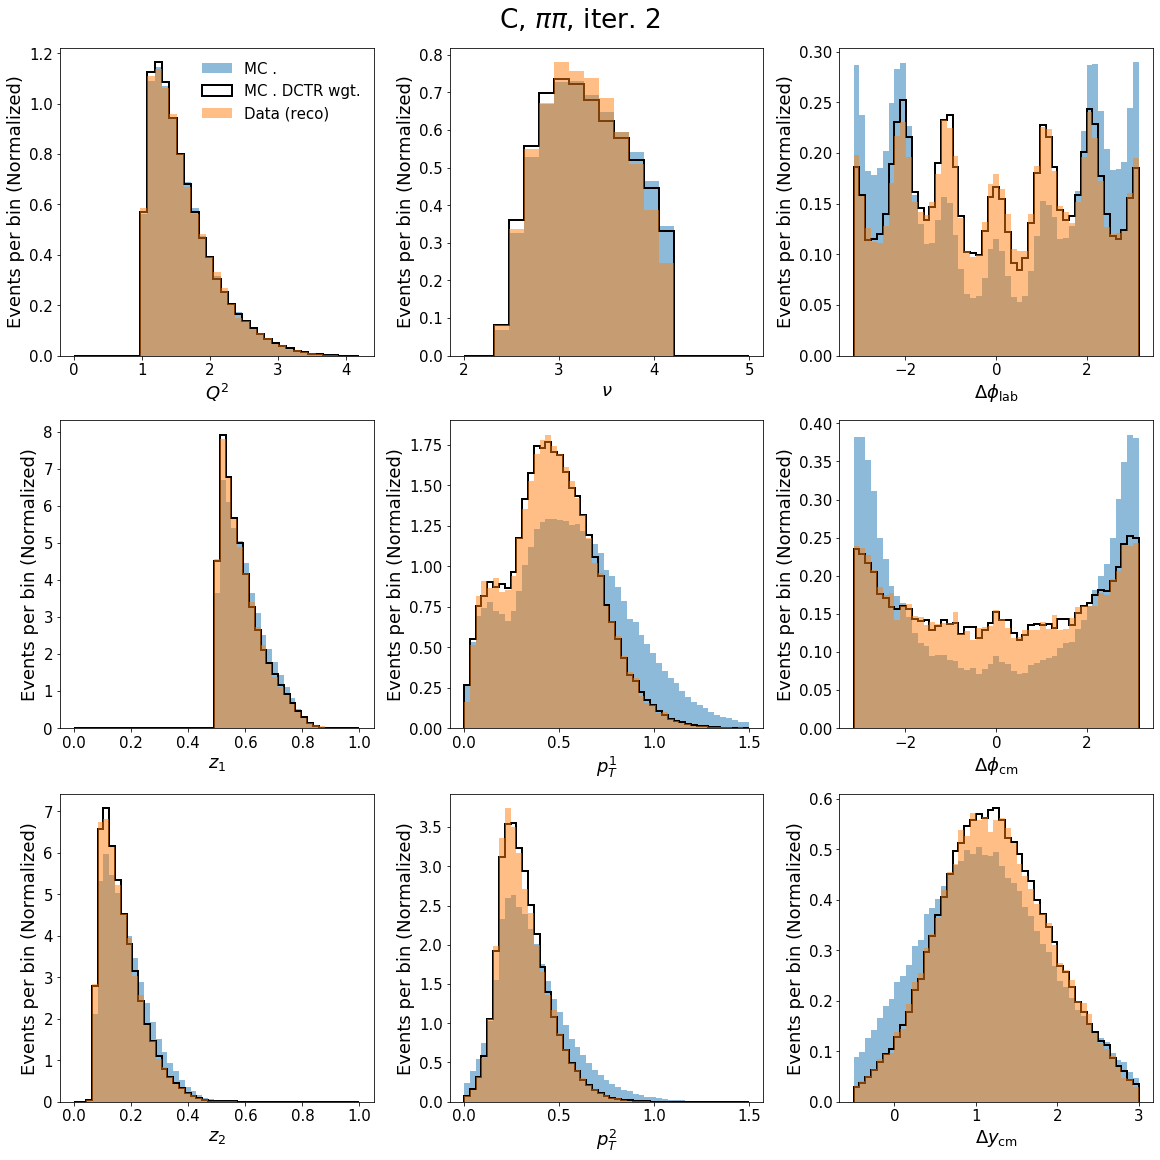

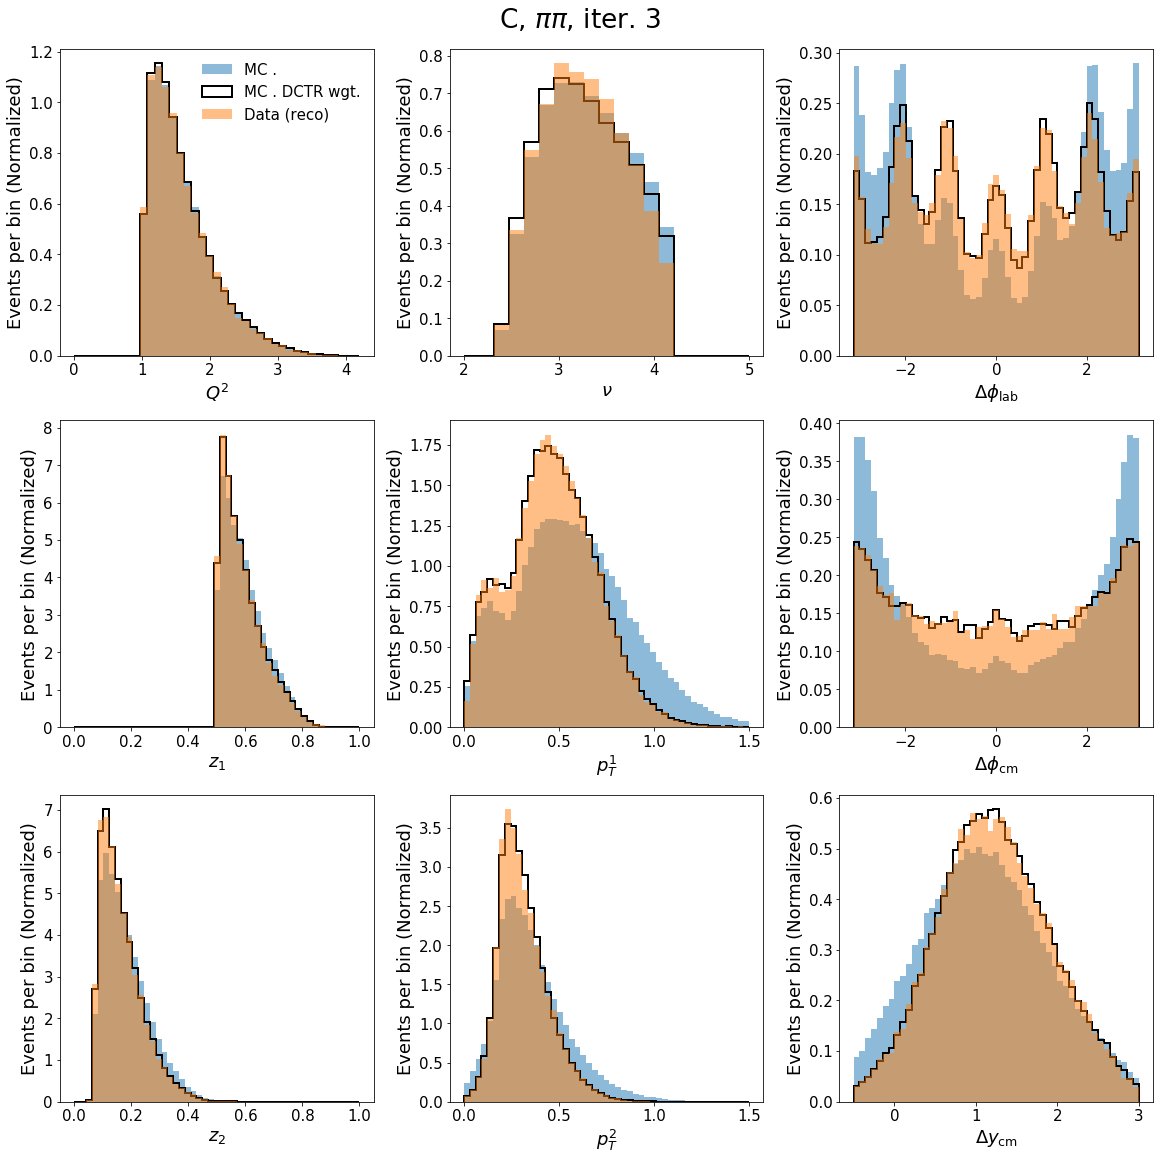

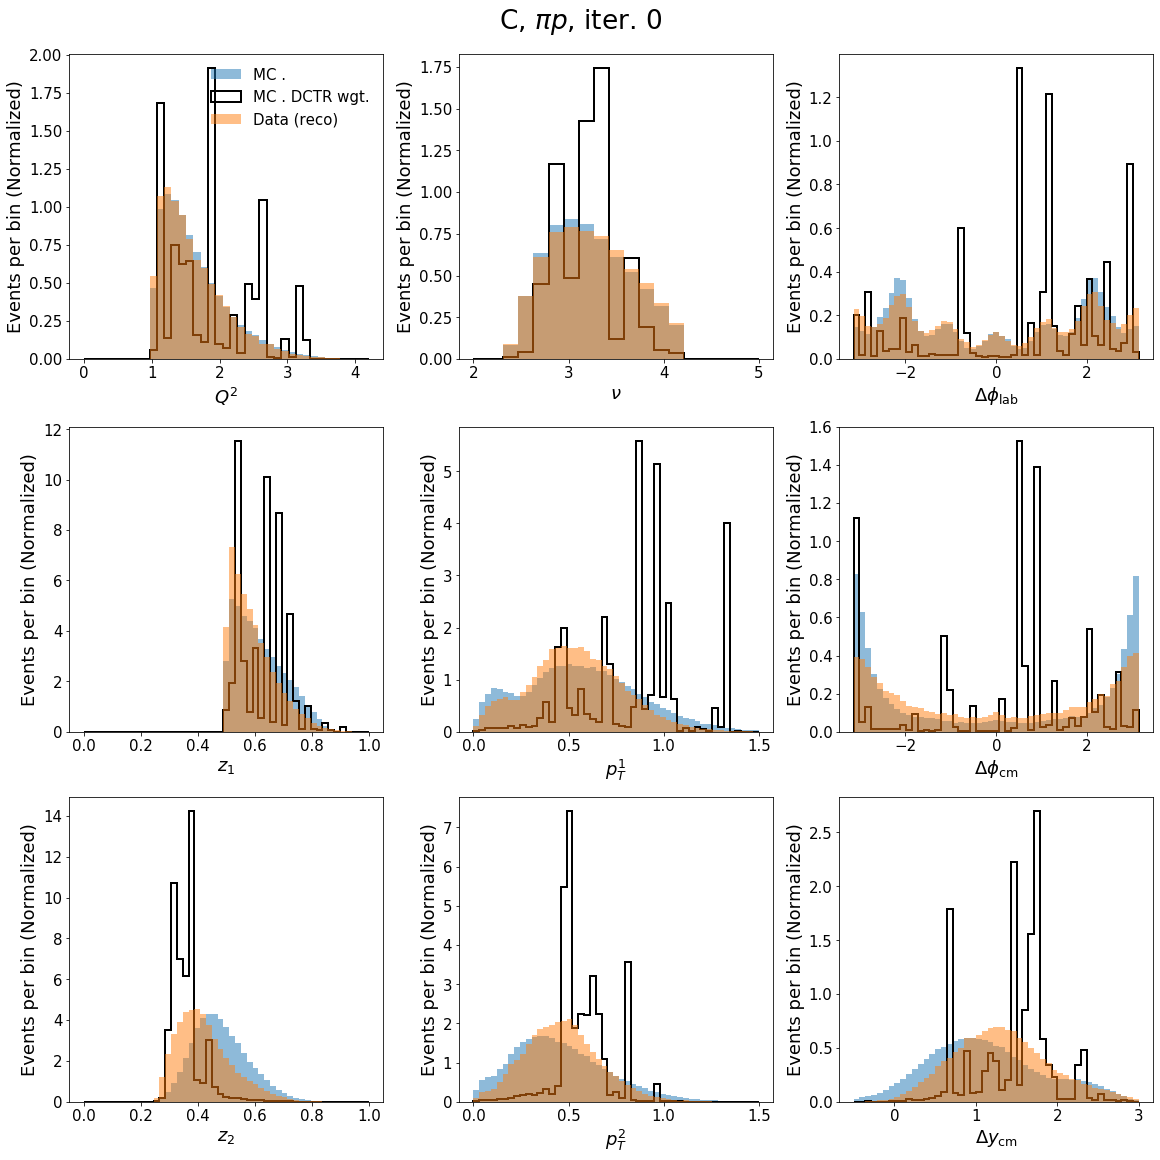

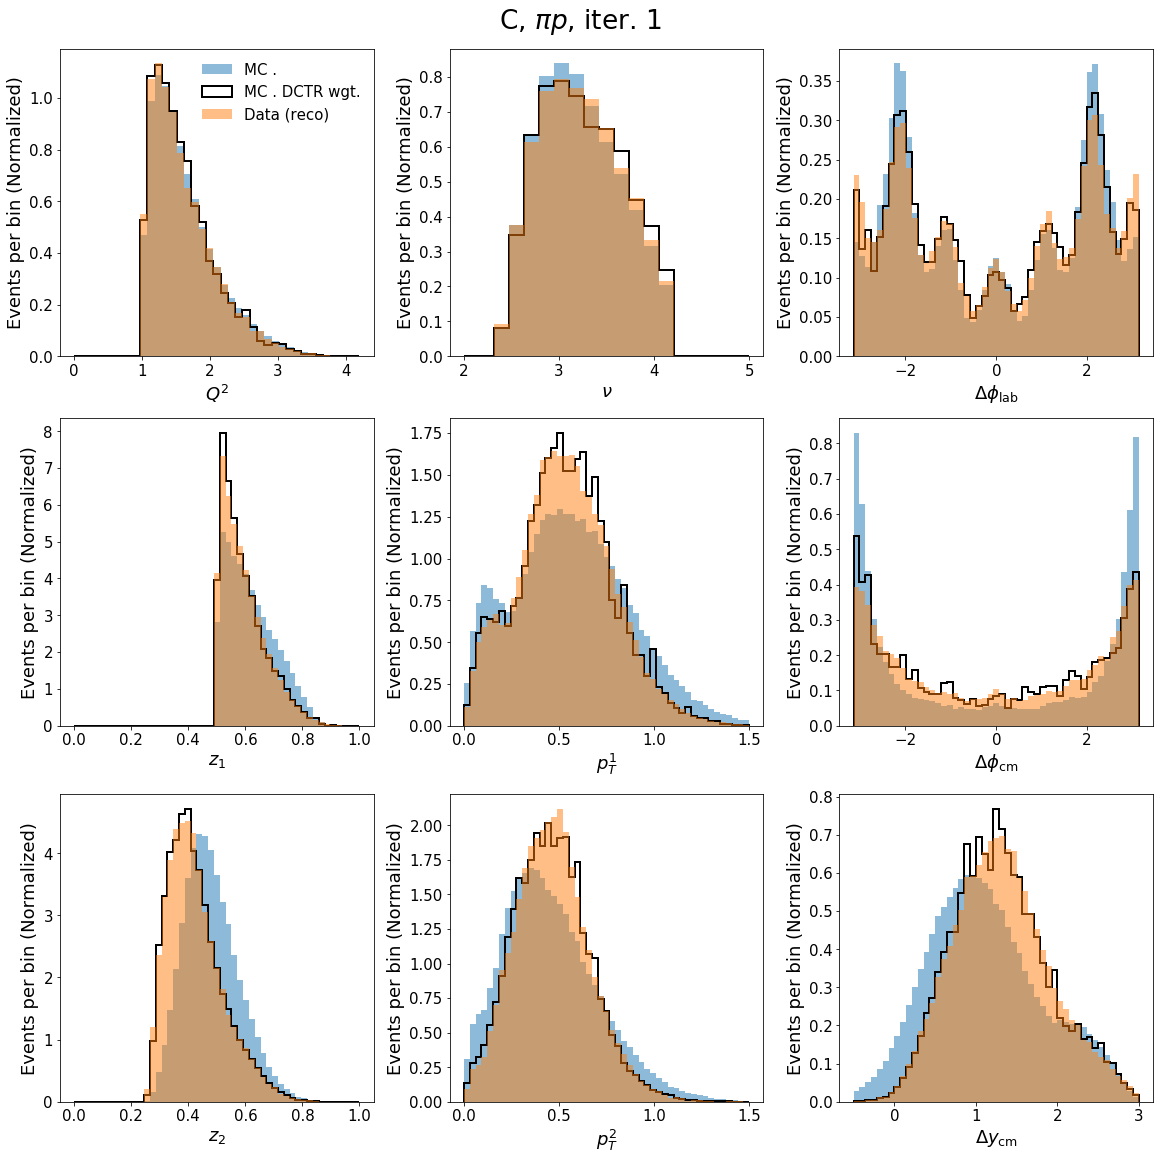

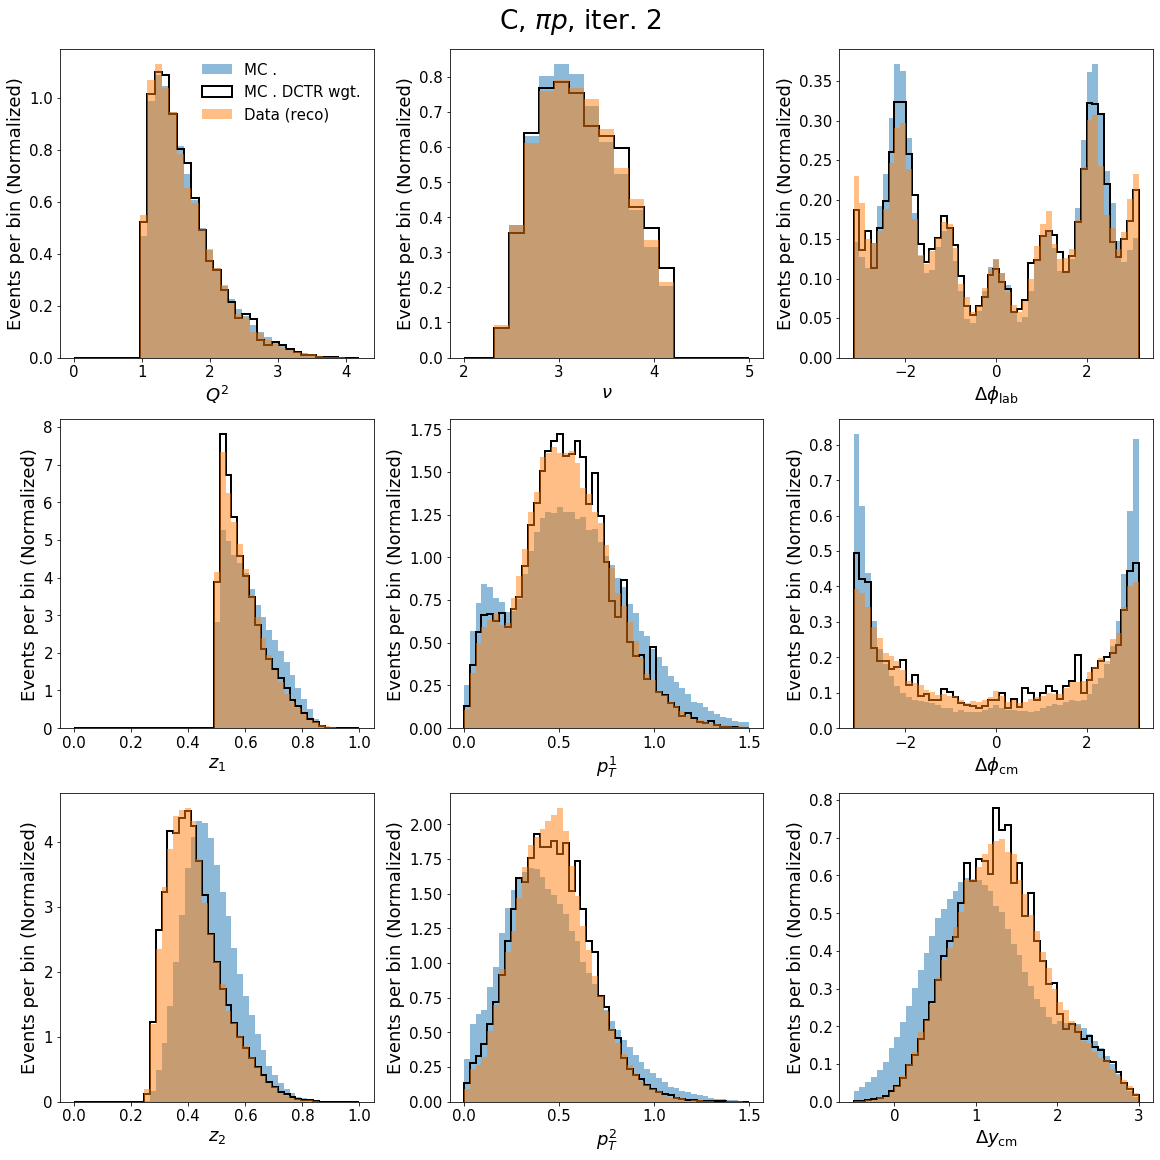

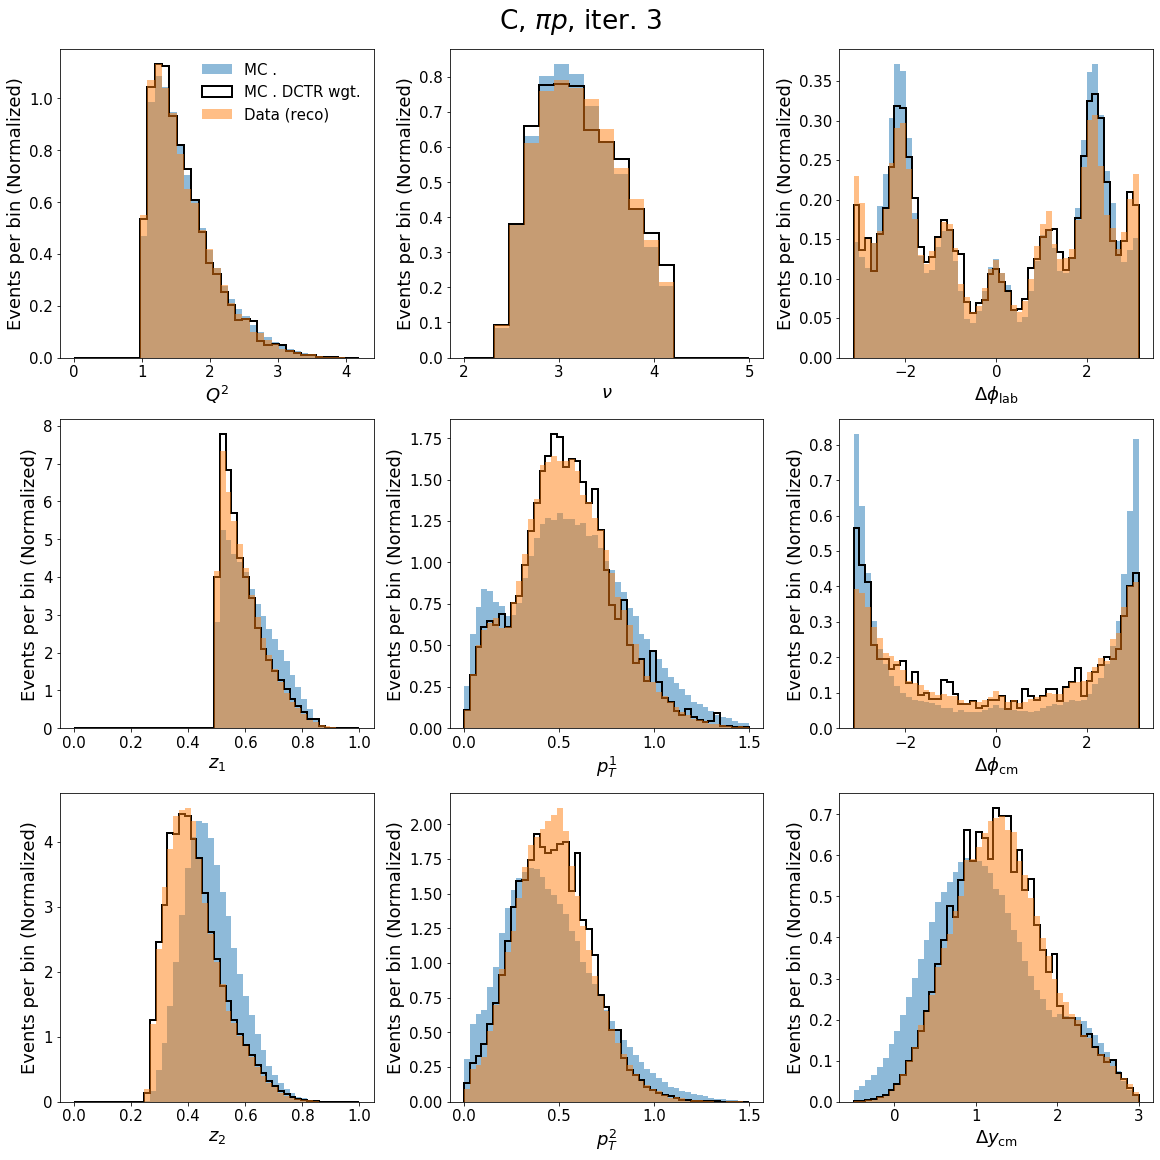

In [131]:
reweight_summary_plots('C_2pi')
reweight_summary_plots('C_pi_p')

## Put weights obtained with the DNN back into the mc dataframe:

In [132]:
for key in weights.keys():
    dfs_mc[key]['weight_reco'] = weights[key][-1, 0, :]
    dfs_mc[key]['weight_truth'] = weights[key][-1, 1, :]
    dfs_mc[key].to_root(f'../in/mc_eg2_weighted_{key}.root',"dihadrons")

# slice plots

In [133]:
def slice_plot(key, xvar,xlabel, bins, slicevar, slicelabel, partitions,suptitle=None):
    df_mc =dfs_mc[key]
    df_data =dfs_data[key]
    fig, axs = plt.subplots(1, len(partitions)-1, 
                            figsize=(4*(len(partitions)-1), 4),sharex='all')
    fig.subplots_adjust(wspace=0)
    if suptitle is not None:
        fig.suptitle(suptitle, y=1.15)
    
    axs[0].set_ylabel('Events per bin (Normalized)')
    for i in range(len(partitions)-1):
        query = f'{slicevar}>{partitions[i]} and {slicevar}<{partitions[i+1]}'
        axs[i].set_xlabel(xlabel)
        axs[i].set_title(f'{partitions[i]} <{slicelabel}<{partitions[i+1]}',fontsize='medium')                 
        mc = df_mc.query(query).query("pass_reco != 0")
        axs[i].hist(mc[xvar], bins=bins, label=r'MC .', **plot_style_2)
        #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

        axs[i].hist(mc[xvar],
                   bins=bins,
                   weights=mc.weight_reco,
                   label=r'MC . DCTR wgt.',
                   **plot_style_1)

        axs[i].hist(df_data.query(query)[xvar],
                   bins=bins,
                   label=r'Data (reco)',
                   **plot_style_2)
        if i==0:
            axs[i].legend(frameon=False,loc='best')
    plt.savefig(f"../images/reweight_eg2_slices_{slicevar}_vs_{xvar}_{key}.png")
        


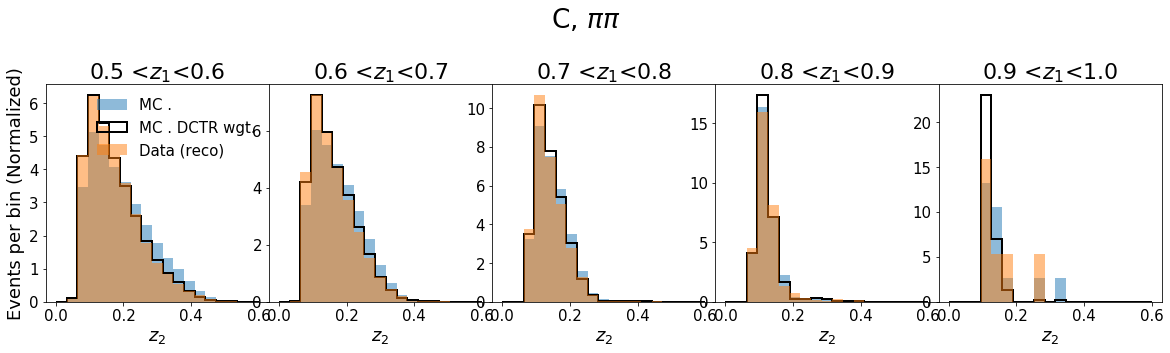

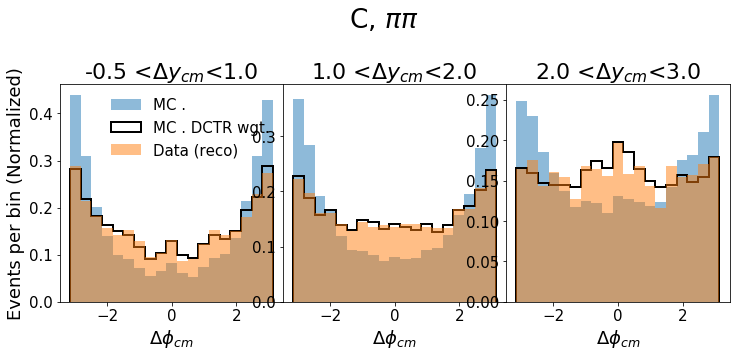

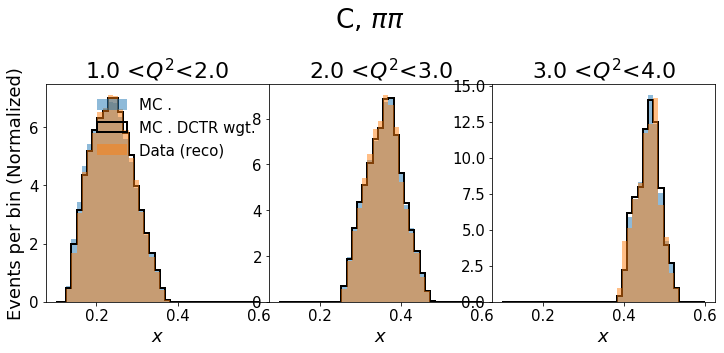

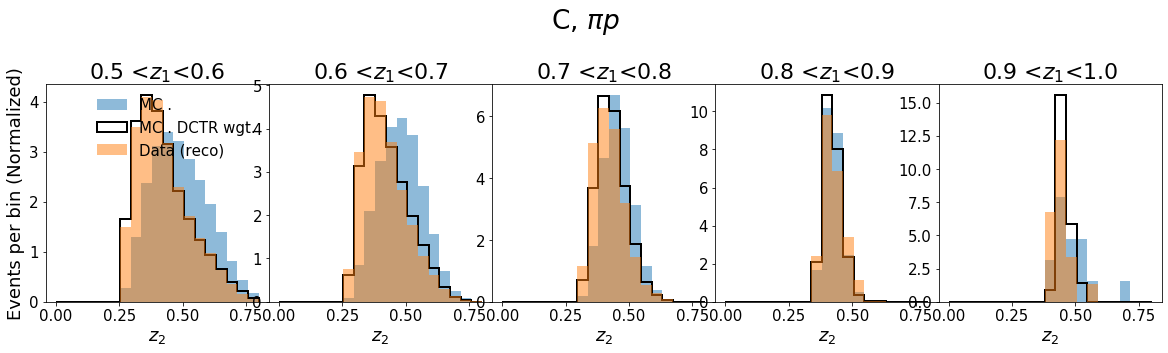

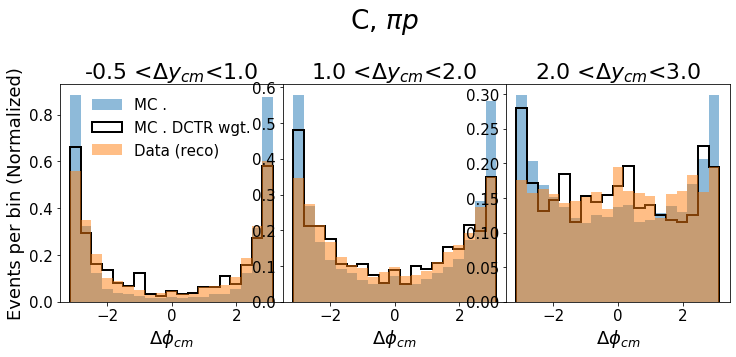

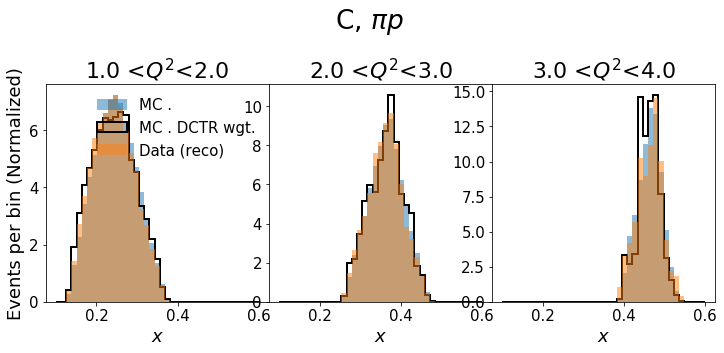

In [134]:

for key in 'C_2pi C_pi_p'.split():
    #determine the suptitle to use
    suptitle = suptitles[key]
    slice_plot(key, 'h2_z', '$z_2$', np.linspace(0,.6 if '2pi' in key else .8, 20), 'h1_z', '$z_1$', np.linspace(0.5,1.0, 6), suptitle=suptitle)
    slice_plot(key, 'diff_phi_cm', r'$\Delta\phi_{cm}$', np.linspace(-np.pi,np.pi, 20), 
           'diff_rap_cm', r'$\Delta y_{cm}$', (-0.5, 1.0, 2.0, 3.0), suptitle=suptitle)
    slice_plot(key, 'x', r'$x$', np.linspace(0.1, 0.6, 40), 
           'Q2', r'$Q^2$', (1.0, 2.0, 3.0, 4.0), suptitle=suptitle)

In [135]:
help(plt.Figure.suptitle)

Help on function suptitle in module matplotlib.figure:

suptitle(self, t, **kwargs)
    Add a centered title to the figure.
    
    Parameters
    ----------
    t : str
        The title text.
    
    x : float, default 0.5
        The x location of the text in figure coordinates.
    
    y : float, default 0.98
        The y location of the text in figure coordinates.
    
    horizontalalignment, ha : {'center', 'left', right'}, default: 'center'
        The horizontal alignment of the text relative to (*x*, *y*).
    
    verticalalignment, va : {'top', 'center', 'bottom', 'baseline'}, default: 'top'
        The vertical alignment of the text relative to (*x*, *y*).
    
    fontsize, size : default: :rc:`figure.titlesize`
        The font size of the text. See `.Text.set_size` for possible
        values.
    
    fontweight, weight : default: :rc:`figure.titleweight`
        The font weight of the text. See `.Text.set_weight` for possible
        values.
    
    
    Returns
